<a href="https://colab.research.google.com/github/spyrosviz/Elderly-Fallers-Prediction/blob/main/Fallers_Prediction_Code/Fallers_Prediction_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import imputed whole dataset
df = pd.read_excel(r"/content/drive/MyDrive/Fallers_prediction/mixed_imputed_dataset.xlsx",index_col=0,skiprows=[1,23,40,50,71,72,73])

# If year falls greater than 0 set to 1
df["Year Fall"] = df["Year Fall"].replace([2,3,4,5,6,7,8,9,10],1)
print(df['Year Fall'].value_counts())

# Set features and Year Fall as target variable
#selected_features = ["tandem_eyes_open",'dom_freq_v','s3(velocity)','Gender(1-female, 0-male)','DGI stairs']
y = df["Year Fall"].values
X = df.drop(['Year Fall','yr almost','6 Months Fall'],axis=1).values
#X = df.loc[:,selected_features].values
X_scaled = MinMaxScaler().fit_transform(X)
#column_names = df.loc[:,selected_features].columns
column_names = df.drop(['Year Fall','yr almost','6 Months Fall'],axis=1).columns
print(column_names)

1    33
0    29
Name: Year Fall, dtype: int64
Index(['GCS (Neurotrax)', 'EFI (Exe. Func. Index)', 'Gender(1-female, 0-male)',
       'Age', 'GDS', 'ABC Tot %', 'SF-36', 'PASE', 'MMSE', 'MoCa', 'FAB',
       'TMTa', 'TMTb', 'TUG', 'FSST', 'BERG', 'DGI', 'DGI stairs',
       'base(velocity)', 's3(velocity)', 'feet close eyes open',
       'feet close eyes closed', 'tandem_eyes_open', 'tandem_eyes_closed',
       'sampen_ap', 'sampen_ml', 'sampen_v', 'dom_freq_ap', 'dom_freq_ampl_ap',
       'dom_freq_width_ap', 'dom_freq_slope_ap', 'dom_freq_ml',
       'dom_freq_ampl_ml', 'dom_freq_width_ml', 'dom_freq_slope_ml',
       'dom_freq_v', 'dom_freq_ampl_v', 'dom_freq_width_v',
       'dom_freq_slope_v'],
      dtype='object')


In [ ]:
# check for multicollinearity

df_vif = pd.DataFrame()
df_vif["Feature"] = column_names
df_vif["VIF"] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
print(df_vif)

                     Feature          VIF
0            GCS (Neurotrax)   932.657216
1     EFI (Exe. Func. Index)   690.741464
2   Gender(1-female, 0-male)     8.456460
3                        Age   815.726897
4                        GDS    11.670312
5                  ABC Tot %   122.463616
6                      SF-36    88.737161
7                       PASE     9.742011
8                       MMSE  1048.716515
9                       MoCa   307.609156
10                       FAB   142.780796
11                      TMTa    46.710405
12                      TMTb    73.001870
13                       TUG   119.029848
14                      FSST    56.295008
15                      BERG  1464.928425
16                       DGI   498.242083
17                DGI stairs    72.776998
18            base(velocity)   232.286663
19              s3(velocity)   125.998555
20      feet close eyes open    15.762245
21    feet close eyes closed    13.978953
22          tandem_eyes_open     7

In [ ]:
'''Random Forest Classifier'''

# create random forest model, fit data and crossvalidate to find best cost complexity parameter

rf = RandomForestClassifier()
gscv1 = GridSearchCV(rf,{'ccp_alpha':np.arange(0.025,1,0.025)},cv=5)
gscv1.fit(X,y)
print("Best param is {}".format(gscv1.best_params_))
print("Best score is {}".format(gscv1.best_score_))

optimal_ccp_alpha = gscv1.best_params_['ccp_alpha']

tuned_rf = RandomForestClassifier(ccp_alpha=optimal_ccp_alpha)
tuned_rf.fit(X,y)
cv1 = cross_val_score(tuned_rf,X,y,cv=5)
print(cv1)
print(np.mean(cv1))

Best param is {'ccp_alpha': 0.07500000000000001}
Best score is 0.6307692307692306
[0.69230769 0.61538462 0.58333333 0.66666667 0.5       ]
0.6115384615384615


In [ ]:
'''AdaBoost'''

# create adaboost model, fit data and crossvalidate to find best learning rate

ab = AdaBoostClassifier()
gscv2 = GridSearchCV(ab,{"learning_rate":np.arange(0.01,1,0.01)},cv=5)
gscv2.fit(X,y)
print("Best parameter is {}".format(gscv2.best_params_))
print("Best score is {}".format(gscv2.best_score_))

optimal_lr = gscv2.best_params_['learning_rate']

ab_tuned = AdaBoostClassifier(learning_rate=optimal_lr)
cv2 = cross_val_score(ab_tuned,X,y,cv=5)
print(cv2)
print(np.mean(cv2))

Best parameter is {'learning_rate': 0.060000000000000005}
Best score is 0.632051282051282
[0.61538462 0.46153846 0.66666667 0.66666667 0.75      ]
0.632051282051282


In [ ]:
'''SVM'''

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
sv = SVC()
gscv3 = GridSearchCV(sv,param_grid,cv=5)
gscv3.fit(X_scaled,y)
print("Best params are {}".format(gscv3.best_params_))
print("Best score is {}".format(gscv3.best_score_))

optimal_C = gscv3.best_params_['C']
optimal_gamma = gscv3.best_params_['gamma']
optimal_kernel = gscv3.best_params_['kernel']

tuned_sv = SVC(C=optimal_C, gamma=optimal_gamma, kernel=optimal_kernel)
cv3 = cross_val_score(tuned_sv,X_scaled,y,cv=5)
print(cv3)
print(np.mean(cv3))

Best params are {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best score is 0.6948717948717948
[0.61538462 0.69230769 0.66666667 0.75       0.75      ]
0.6948717948717948


In [ ]:
'''Naive Bayes'''

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
gscv4 = GridSearchCV(nb,{'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]},cv=5)
gscv4.fit(X,y)
print("Best parameter is {}".format(gscv4.best_params_))
print("Best score is {}".format(gscv4.best_score_))

optimal_alpha = gscv4.best_params_['alpha']

tuned_nb = MultinomialNB(alpha=optimal_alpha)
cv4 = cross_val_score(tuned_nb,X,y,cv=5)
print(cv4)
print(np.mean(cv4))

Best parameter is {'alpha': 0.0001}
Best score is 0.5653846153846154
[0.38461538 0.69230769 0.58333333 0.58333333 0.58333333]
0.5653846153846154


In [ ]:
'''KNN'''

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
gscv5 = GridSearchCV(knn,{'n_neighbors':np.arange(1,10,1)},cv=5)
gscv5.fit(X_scaled,y)
print("Best parameter is {}".format(gscv5.best_params_))
print("Best score is {}".format(gscv5.best_score_))

optimal_n_neighbors = gscv5.best_params_['n_neighbors']

tuned_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
cv5 = cross_val_score(tuned_knn,X,y,cv=5)
print(cv5)
print(np.mean(cv5))

Best parameter is {'n_neighbors': 6}
Best score is 0.632051282051282
[0.69230769 0.53846154 0.58333333 0.5        0.5       ]
0.5628205128205128


In [ ]:
'''Logistic Regression'''

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

log_reg = LogisticRegression()
param_gr = {'penalty':['l1', 'l2', 'elasticnet', 'none'],'C':[0.001,0.01,0.1,1,10,100]}
gscv6 = GridSearchCV(log_reg,param_gr,cv=5)
gscv6.fit(X,y)
print("Best parameter is {}".format(gscv6.best_params_))
print("Best score is {}".format(gscv6.best_score_))

opt_C = gscv6.best_params_['C']
opt_penalty = gscv6.best_params_['penalty']

tuned_log_reg = LogisticRegression(C=opt_C,penalty=opt_penalty)
cv6 = cross_val_score(tuned_log_reg,X,y,cv=5)
print(cv6)
print(np.mean(cv6))

Best parameter is {'C': 0.001, 'penalty': 'none'}
Best score is 0.6128205128205129
[0.69230769 0.53846154 0.58333333 0.58333333 0.66666667]
0.6128205128205129


In [ ]:
''' Gradient Boosting Classifier'''

gb = GradientBoostingClassifier()
gscv7 = RandomizedSearchCV(gb,{"min_impurity_decrease":np.arange(0.01,1,0.01),'n_estimators':np.arange(10,300,10),'learning_rate':np.arange(0.01,1,0.01)},cv=5)
gscv7.fit(X,y)
print("Best param is {}".format(gscv7.best_params_))
print("Best score is {}".format(gscv7.best_score_))

optimal_min_impurity_decrease = gscv7.best_params_['min_impurity_decrease']
optimal_n_estimators = gscv7.best_params_['n_estimators']
opt_lr = gscv7.best_params_['learning_rate']

tuned_gb = GradientBoostingClassifier(min_impurity_decrease=optimal_min_impurity_decrease,n_estimators=optimal_n_estimators,learning_rate=opt_lr)
cv7 = cross_val_score(tuned_gb,X,y,cv=5)
print(cv7)
print(np.mean(cv7))

Best param is {'n_estimators': 190, 'min_impurity_decrease': 0.8300000000000001, 'learning_rate': 0.9400000000000001}
Best score is 0.5474358974358975
[0.53846154 0.53846154 0.58333333 0.58333333 0.25      ]
0.4987179487179487


In [ ]:
'''XGBoost'''

xgb = XGBClassifier()
gscv8 = RandomizedSearchCV(xgb,{"gamma":[0.01,0.1,1,10,50,100,1000],'n_estimators':np.arange(50,1000,50),'learning_rate':np.arange(0.01,1,0.01),'eta':np.arange(0.1,1,0.1),'objective':['binary:logistic','reg:squarederror','multi:softprob','binary:hinge']},cv=5)
gscv8.fit(X,y)
print("Best param is {}".format(gscv8.best_params_))
print("Best score is {}".format(gscv8.best_score_))

optimal_gamma = gscv8.best_params_['gamma']
optimal_n_est = gscv8.best_params_['n_estimators']
optim_lr = gscv8.best_params_['learning_rate']
optimal_eta = gscv8.best_params_['eta']
optimal_obj = gscv8.best_params_['objective']


tuned_xgb = XGBClassifier(gamma=optimal_gamma,n_estimators=optimal_n_est,learning_rate=optim_lr,eta=optimal_eta,objective=optimal_obj)
cv8 = cross_val_score(tuned_xgb,X,y,cv=5)
print(cv8)
print(np.mean(cv8))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 

Best param is {'objective': 'reg:squarederror', 'n_estimators': 950, 'learning_rate': 0.35000000000000003, 'gamma': 100, 'eta': 0.6}
Best score is 0.532051282051282
[0.53846154 0.53846154 0.5        0.5        0.58333333]
0.532051282051282


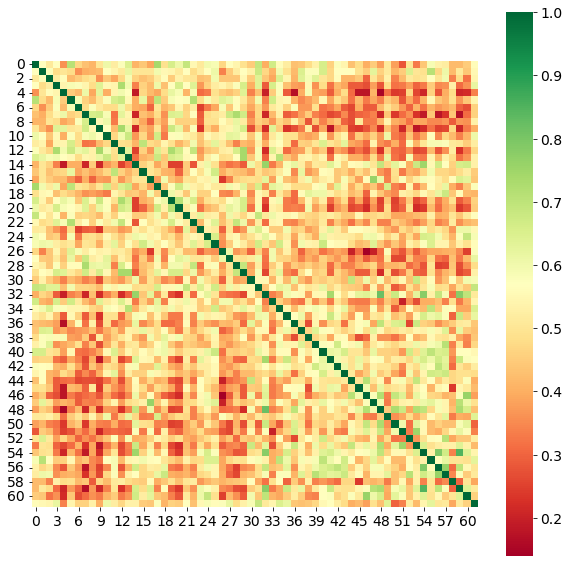

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:518: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  "The MDS API has changed. ``fit`` now constructs an"


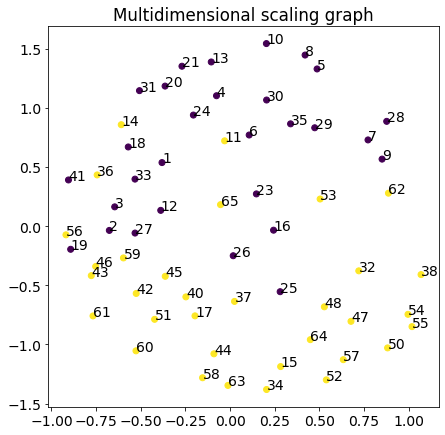

168.68990552654847


In [ ]:
'''Proximity Matrix Clustering and metric MDS'''

tuned_rf.fit(X,y)

#make proximity matrix to cluster subjects
def proximityMatrix(model, X, normalize=True):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

prox_matrix = proximityMatrix(tuned_rf, X, normalize=True)
#make a heatmap from proximity matrix to find subjects clustering together
plt.figure(figsize=[10,10])
sns.heatmap(prox_matrix,square=True,cmap="RdYlGn")
plt.show()

#make MDS plot with proximity matrix to find subjects clustering together
mds = MDS(n_components=2,random_state=0,metric=True)
mds_coordinates = mds.fit_transform(prox_matrix)

mds_df = pd.DataFrame(mds_coordinates,columns=["x","y"],index=df.index)
mds_df = pd.concat([mds_df,pd.Series(df['Year Fall'])],axis=1)
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
plt.scatter(mds_df.x, mds_df.y,c=mds_df['Year Fall'])
plt.title('Multidimensional scaling graph')
for sample in mds_df.index:
    plt.annotate(sample,(mds_df.x.loc[sample],mds_df.y.loc[sample]))
plt.show()